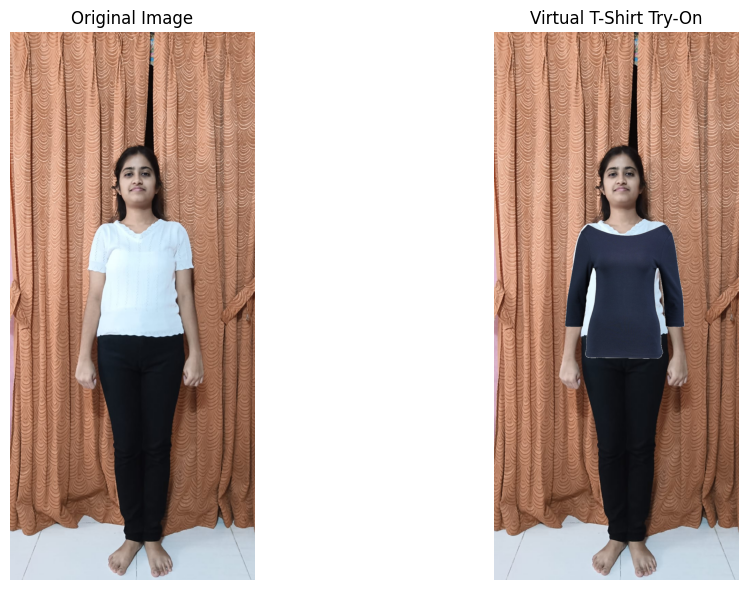

In [71]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import mediapipe as mp

# Initialize MediaPipe Pose
mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils
pose = mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.5)

# Load images
original_img = cv2.imread(r"C:\Users\User\Downloads\Project_Kurti\HP\HP & PE dataset\TK_141.jpeg")
tshirt_img = cv2.imread(r"C:\Users\User\Downloads\archive (1)\zalando-hd-resized\train\cloth\00162_00.jpg")

# Create a copy for processing
result_img = original_img.copy()

# Convert BGR to RGB
rgb_image = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
tshirt_rgb = cv2.cvtColor(tshirt_img, cv2.COLOR_BGR2RGB)

# Process the image to find pose
results = pose.process(rgb_image)

if results.pose_landmarks:
    # Get relevant landmarks
    landmarks = results.pose_landmarks.landmark
    
    # Get image dimensions
    h, w, _ = original_img.shape
    
    # Get shoulder positions
    left_shoulder = (int(landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER].x * w),
                     int(landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER].y * h))
    right_shoulder = (int(landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER].x * w),
                      int(landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER].y * h))
    
    # Calculate t-shirt dimensions based on shoulder width
    shoulder_width = abs(right_shoulder[0] - left_shoulder[0])
    tshirt_width = int(shoulder_width * 2.0)  # Adjust as needed
    
    # Calculate aspect ratio for t-shirt
    tshirt_height = int(tshirt_width * tshirt_img.shape[0] / tshirt_img.shape[1])
    
    # Calculate position for t-shirt (centered on shoulders)
    tshirt_x = max(0, int((left_shoulder[0] + right_shoulder[0]) / 2 - tshirt_width / 2))
    tshirt_y = int(left_shoulder[1] - tshirt_height * 0.2)  # Adjust to position the neck of the shirt
    
    # Resize t-shirt
    resized_tshirt = cv2.resize(tshirt_rgb, (tshirt_width, tshirt_height))
    
    # Create a simple mask for the t-shirt (can be improved)
    # Assuming lighter colors in the t-shirt are the background
    gray_tshirt = cv2.cvtColor(resized_tshirt, cv2.COLOR_RGB2GRAY)
    _, mask = cv2.threshold(gray_tshirt, 240, 255, cv2.THRESH_BINARY_INV)
    mask = cv2.merge([mask, mask, mask]) / 255.0
    
    # Define the region to overlay the t-shirt
    y_end = min(tshirt_y + tshirt_height, h)
    x_end = min(tshirt_x + tshirt_width, w)
    overlay_height = y_end - tshirt_y
    overlay_width = x_end - tshirt_x
    
    if overlay_height > 0 and overlay_width > 0:
        overlay_region = rgb_image[tshirt_y:y_end, tshirt_x:x_end]
        
        # Resize t-shirt and mask to match overlay region
        resized_tshirt = resized_tshirt[:overlay_height, :overlay_width]
        mask = mask[:overlay_height, :overlay_width]
        
        # Blend images
        blended = (mask * resized_tshirt + (1 - mask) * overlay_region).astype(np.uint8)
        
        # Update the result image
        result_img_rgb = cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB)
        result_img_rgb[tshirt_y:y_end, tshirt_x:x_end] = blended
        result_img = cv2.cvtColor(result_img_rgb, cv2.COLOR_RGB2BGR)

# Convert result to RGB for display
result_img_rgb = cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB)
original_img_rgb = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)

# Display results
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(original_img_rgb)
plt.axis('off')
plt.subplot(1, 2, 2)
plt.title('Virtual T-Shirt Try-On')
plt.imshow(result_img_rgb)
plt.axis('off')
plt.tight_layout()
plt.show()

# Release resources
pose.close()